Архитектура модели анализа кода

В данном файле проводится инициализация модели и её обучение

Импортируем необходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import os

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from torch.utils.tensorboard import summary, writer, SummaryWriter
from tqdm import tqdm
import time
import datetime

Устанавливаем SEED

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

import warnings
warnings.filterwarnings("ignore")

Далее считываем исходный датасет и немного дорабатываем его

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/input_code_dataset_inference_upd.csv'

In [5]:
code_dataset = pd.read_csv(dataset_path)

In [6]:
code_dataset = code_dataset.reset_index(drop=True)

In [7]:
def remove_after_token(text, token='<INFO_TOKEN>'):
    index = text.find(token)
    if index != -1:
        return text[:index]
    return text

code_dataset['input_string_focal_method'] = code_dataset['input_string_focal_method'].apply(remove_after_token)

In [8]:
code_dataset.head()

Unnamed: 0  index                                           Function  \
0           0      0  def is_even(n):\n    if n < 0:\n        print(...   
1           1      1  def factorial(n):\n    if n < 0:\n        prin...   
2           2      2  def count_vowels(s):\n    vowels = "aeiou"\n  ...   
3           3      3  def count_even_numbers(lst):\n    even_count =...   
4           4      4  def sum_up_to_n(n):\n    if n < 0:\n        pr...   

                                                Test  \
0  def test_is_even():\n    assert is_even(4) is ...   
1  def test_factorial():\n    assert factorial(5)...   
2  def test_count_vowels():\n    assert count_vow...   
3  def test_count_even_numbers():\n    assert cou...   
4  def test_sum_up_to_n():\n    assert sum_up_to_...   

                                    AST_FOCAL_METHOD  \
0  Module(\n    body=[\n        FunctionDef(\n   ...   
1  Module(\n    body=[\n        FunctionDef(\n   ...   
2  Module(\n    body=[\n        FunctionDef(\n   ...   
3  Module(\n    body=[\n        FunctionDef(\n   ...   
4  Module(\n    body=[\n        FunctionDef(\n   ...   

                              input_string_focal_cls  \
0  <CLS_TOKEN> <FUNC_TOKEN> <INFO_TOKEN> <DESCRIP...   
1  <CLS_TOKEN> <FUNC_TOKEN> <INFO_TOKEN> <DESCRIP...   
2  <CLS_TOKEN> <FUNC_TOKEN> <INFO_TOKEN> <DESCRIP...   
3  <CLS_TOKEN> <FUNC_TOKEN> <INFO_TOKEN> <DESCRIP...   
4  <CLS_TOKEN> <FUNC_TOKEN> <INFO_TOKEN> <DESCRIP...   

                           input_string_focal_method  \
0  def is_even(n):\n    if n < 0:\n        print(...   
1  def factorial(n):\n    if n < 0:\n        prin...   
2  def count_vowels(s):\n    vowels = "aeiou"\n  ...   
3  def count_even_numbers(lst):\n    even_count =...   
4  def sum_up_to_n(n):\n    if n < 0:\n        pr...   

                                        input_string  
0  def is_even(n):\n    if n < 0:\n        print(...  
1  def factorial(n):\n    if n < 0:\n        prin...  
2  def count_vowels(s):\n    vowels = "aeiou"\n  ...  
3  def count_even_numbers(lst):\n    even_count =...  
4  def sum_up_to_n(n):\n    if n < 0:\n        pr...

Наконец, переходим к анализу архитектур нейросетей

Решено использовать подход, основанный на обучении (fine-tuning) нейросети GPTBigCode, в основе которой лежит модель GPT-2, предобученная на DownStream задачах, связанных с чтением кода на разных языках программирования (мультиязычная модель).

In [9]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

Device:

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 20 12:26:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              46W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [12]:
# from transformers import GPT2LMHeadModel, AutoConfig

class LargeCodeModelGPTBigCode(nn.Module):
	'''Класс для сложной языковой модели, которая обрабатывает входной код'''
	def __init__(self, gpt2_name):
		super(LargeCodeModelGPTBigCode, self).__init__()

		self.new_special_tokens = ['<FUNC_TOKEN>',
            '<INFO_TOKEN>',
            '<CLS_TOKEN>',
            '<AST_TOKEN>',
            '<DESCRIPTION_TOKEN>',
            '<COMMENTS_TOKEN>']

		self.special_tokens_dict = {
			'additional_special_tokens': self.new_special_tokens
		}

		self.tokenizerGPT = AutoTokenizer.from_pretrained(gpt2_name, padding_side='left')
		self.tokenizerGPT.add_special_tokens({'pad_token': '<PAD>'})
		self.tokenizerGPT.add_special_tokens(self.special_tokens_dict)
		self.gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name)
		# riprint(f"PAD token ID: {self.tokenizerGPT.pad_token_id}")  # Должно быть ненулевое значение
		# pnt(f"PAD token: {self.tokenizerGPT.pad_token}")       # Должно быть '<PAD>'

		self.gpt2.resize_token_embeddings(len(self.tokenizerGPT))

	# forward call
	def forward(self, input_ids, attention_mask,
			 	response_ids, response_attention_mask):


		gpt2_outputs = self.gpt2(input_ids = input_ids,
						   attention_mask = attention_mask,
						   labels = response_ids)

		return gpt2_outputs


In [13]:
# torch.cuda.empty_cache()

In [14]:
CodeModel = LargeCodeModelGPTBigCode(gpt2_name="bigcode/gpt_bigcode-santacoder").to(device)

In [15]:
# prompt_string = "Generate test cases for a given Python function using its source code and AST. The output should be a series of assert statements that verify the function's correctness. \n\nExample:\n\nInput: <FUNC_TOKEN> def add(a, b): return a + b <AST_TOKEN> Module( body=[ FunctionDef( name='add', args=arguments( posonlyargs=[], args=[ arg(arg='a'), arg(arg='b')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[ Return( value=BinOp( left=Name(id='a', ctx=Load()), op=Add(), right=Name(id='b', ctx=Load())))], decorator_list=[], type_params=[])], type_ignores=[]) \n\nOutput: def test_add(a, b):\n\n\tassert add(1, 2) == 3\n\tassert add(-1, 1) == 0\n\tassert add(0, 0) == 0\n\tassert add(1.5, 2.5) == 4.0\n\nMy Input:\n\n"
prompt_string = "Generate test cases for a given Python function using its source code. The output should be a series of assert statements that verify the function's correctness. \n\nExample:\n\nInput:\n\ndef add(a, b):\n\treturn a + b\n \n\nOutput:\n\ndef test_add(a, b):\n\n\tassert add(1, 2) == 3\n\tassert add(-1, 1) == 0\n\tassert add(0, 0) == 0\n\tassert add(1.5, 2.5) == 4.0\n\nMy Input:\n\n"
code_dataset['input_string'] = prompt_string + code_dataset['Function'] + "\n\nMy Output:\n\n" + code_dataset['Test']
code_dataset['input_string_focal_method'] = prompt_string + code_dataset['Function'] + "\n" + "\n\nMy Output:\n\n"

In [16]:
print(code_dataset['input_string'].values[0])

Generate test cases for a given Python function using its source code and. The output should be a series of assert statements that verify the function's correctness. 

Example:

Input:

def add(a, b):
	return a + b
 

Output:

def test_add(a, b):

	assert add(1, 2) == 3
	assert add(-1, 1) == 0
	assert add(0, 0) == 0
	assert add(1.5, 2.5) == 4.0

My Input:

def is_even(n):
    if n < 0:
        print("Negative number, can't be checked for evenness.")
        return False
    if n % 2 == 0:
        return True
    else:
        if n == 1:
            print("One is odd!")
        return False

My Output:

def test_is_even():
    assert is_even(4) is True
    assert is_even(0) is True
    assert is_even(2) is True
    assert is_even(3) is False
    assert is_even(1) is False
    assert is_even(7) is False
    assert is_even(-2) is False
    assert is_even(-3) is False
    assert is_even(-7) is False


In [17]:
print(code_dataset['input_string_focal_method'].values[0])

Generate test cases for a given Python function using its source code and. The output should be a series of assert statements that verify the function's correctness. 

Example:

Input:

def add(a, b):
	return a + b
 

Output:

def test_add(a, b):

	assert add(1, 2) == 3
	assert add(-1, 1) == 0
	assert add(0, 0) == 0
	assert add(1.5, 2.5) == 4.0

My Input:

def is_even(n):
    if n < 0:
        print("Negative number, can't be checked for evenness.")
        return False
    if n % 2 == 0:
        return True
    else:
        if n == 1:
            print("One is odd!")
        return False


My Output:




In [18]:
code_dataset.rename(columns={'Test': 'response'}, inplace=True)

Shuffle

In [19]:
code_dataset = code_dataset.sample(frac=1).reset_index(drop=True)

Далее необхоимо описать класс Dataset для нашей модели

In [20]:
class Code2TestDataset(Dataset):
	'''Класс датасет для задачи генерации тестов'''

	def __init__(self, code_dataset, tokenizer_gpt, max_length=512):
		'''
		Конструктор датасета

		Параметры:
		- code_dataset: датасет pd.DataFrame
		- tokenizer_gpt: токенизатор gpt
		- max_length: максимальная длина последовательности (default: 512)
		'''
		self.code_dataset = code_dataset
		self.tokenizer_gpt = tokenizer_gpt
		self.max_length = max_length

	def __getitem__(self, idx, idx_to_token=False):
		'''
		Get-метод - возвращает сэмпл по индексу

		Параметры:
		- idx: индекс
		- idx_to_token: флаг для отображения токенов из индексов (default: False)
		'''
		input = self.code_dataset.at[idx, 'input_string']
		response = self.code_dataset.at[idx, 'response']
		input_for_val = self.code_dataset.at[idx, 'input_string_focal_method']

		def encode_text(text, tokenizer):
			encoding = tokenizer.encode_plus(
				text,
				add_special_tokens=True,
				max_length=self.max_length,
				padding='max_length',
				truncation=True,
				return_attention_mask=True,
				return_tensors='pt',
			)
			input_ids = encoding['input_ids'].flatten()
			attention_mask = encoding['attention_mask'].flatten()
			return input_ids, attention_mask

		input_ids, attention_mask = encode_text(input, self.tokenizer_gpt)
		input_ids_response, attention_mask_response = encode_text(response, self.tokenizer_gpt)
		input_ids_for_val, attention_mask_for_val = encode_text(input_for_val, self.tokenizer_gpt)

		if idx_to_token:
			return {
					 'input_ids': self.tokenizer_gpt.convert_ids_to_tokens(input_ids),
					 'attention_mask': attention_mask,
					 'input_ids_response': self.tokenizer_gpt.convert_ids_to_tokens(input_ids),
					 'attention_mask_response': attention_mask_response,
					 'input_ids_for_val': self.tokenizer_gpt.convert_ids_to_tokens(input_ids_for_val),
					 'attention_mask_for_val': attention_mask_for_val
			}
		return {
				 'input_ids': input_ids,
				'attention_mask': attention_mask,
				'input_ids_response': input_ids,
				'attention_mask_response': attention_mask_response,
				'input_ids_for_val': input_ids_for_val,
				'attention_mask_for_val': attention_mask_for_val
		}

	def __len__(self):
		'''Функция возвращает длину датасета. В качестве длины берется размер датасета по axis = 0'''
		return self.code_dataset.shape[0]


Тестируем написанный класс

In [21]:
code2test_dataset = Code2TestDataset(code_dataset=code_dataset,
                                     tokenizer_gpt=CodeModel.tokenizerGPT)

In [22]:
print(code2test_dataset.__getitem__(0, True)['input_ids'])

['Generate', 'Ġtest', 'Ġcases', 'Ġfor', 'Ġa', 'Ġgiven', 'ĠPython', 'Ġfunction', 'Ġusing', 'Ġits', 'Ġsource', 'Ġcode', 'Ġand', '.', 'ĠThe', 'Ġoutput', 'Ġshould', 'Ġbe', 'Ġa', 'Ġseries', 'Ġof', 'Ġassert', 'Ġstatements', 'Ġthat', 'Ġverify', 'Ġthe', 'Ġfunction', "'s", 'Ġcorrect', 'ness', '.', 'ĠĊ', 'Ċ', 'Example', ':', 'Ċ', 'Ċ', 'Input', ':', 'Ċ', 'Ċ', 'def', 'Ġadd', '(', 'a', ',', 'Ġb', '):', 'Ċ', 'ĉ', 'return', 'Ġa', 'Ġ+', 'Ġb', 'ĊĠĊ', 'Ċ', 'Output', ':', 'Ċ', 'Ċ', 'def', 'Ġtest', '_', 'add', '(', 'a', ',', 'Ġb', '):', 'ĊĊ', 'ĉ', 'assert', 'Ġadd', '(', '1', ',', 'Ġ', '2', ')', 'Ġ==', 'Ġ', '3', 'Ċ', 'ĉ', 'assert', 'Ġadd', '(-', '1', ',', 'Ġ', '1', ')', 'Ġ==', 'Ġ', '0', 'Ċ', 'ĉ', 'assert', 'Ġadd', '(', '0', ',', 'Ġ', '0', ')', 'Ġ==', 'Ġ', '0', 'Ċ', 'ĉ', 'assert', 'Ġadd', '(', '1', '.', '5', ',', 'Ġ', '2', '.', '5', ')', 'Ġ==', 'Ġ', '4', '.', '0', 'Ċ', 'Ċ', 'My', 'ĠInput', ':', 'Ċ', 'Ċ', 'def', 'Ġmultiply', '_', 'by', '_', 'diff', '_', 'of', '_', 'other', '_', 'list', '(', 'lst', '1', ',', 

In [23]:
print(code2test_dataset.__getitem__(0, True)['input_ids_response'])

['Generate', 'Ġtest', 'Ġcases', 'Ġfor', 'Ġa', 'Ġgiven', 'ĠPython', 'Ġfunction', 'Ġusing', 'Ġits', 'Ġsource', 'Ġcode', 'Ġand', '.', 'ĠThe', 'Ġoutput', 'Ġshould', 'Ġbe', 'Ġa', 'Ġseries', 'Ġof', 'Ġassert', 'Ġstatements', 'Ġthat', 'Ġverify', 'Ġthe', 'Ġfunction', "'s", 'Ġcorrect', 'ness', '.', 'ĠĊ', 'Ċ', 'Example', ':', 'Ċ', 'Ċ', 'Input', ':', 'Ċ', 'Ċ', 'def', 'Ġadd', '(', 'a', ',', 'Ġb', '):', 'Ċ', 'ĉ', 'return', 'Ġa', 'Ġ+', 'Ġb', 'ĊĠĊ', 'Ċ', 'Output', ':', 'Ċ', 'Ċ', 'def', 'Ġtest', '_', 'add', '(', 'a', ',', 'Ġb', '):', 'ĊĊ', 'ĉ', 'assert', 'Ġadd', '(', '1', ',', 'Ġ', '2', ')', 'Ġ==', 'Ġ', '3', 'Ċ', 'ĉ', 'assert', 'Ġadd', '(-', '1', ',', 'Ġ', '1', ')', 'Ġ==', 'Ġ', '0', 'Ċ', 'ĉ', 'assert', 'Ġadd', '(', '0', ',', 'Ġ', '0', ')', 'Ġ==', 'Ġ', '0', 'Ċ', 'ĉ', 'assert', 'Ġadd', '(', '1', '.', '5', ',', 'Ġ', '2', '.', '5', ')', 'Ġ==', 'Ġ', '4', '.', '0', 'Ċ', 'Ċ', 'My', 'ĠInput', ':', 'Ċ', 'Ċ', 'def', 'Ġmultiply', '_', 'by', '_', 'diff', '_', 'of', '_', 'other', '_', 'list', '(', 'lst', '1', ',', 

In [24]:
print(code2test_dataset.__getitem__(0, True)['input_ids_for_val'])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

In [25]:
code2test_dataset[0]['attention_mask']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [26]:
code2test_dataset[0]['attention_mask_response']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [27]:
code2test_dataset[0]['attention_mask_for_val']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
print(f"Длина датасета составляет: {len(code2test_dataset)}")

Длина датасета составляет: 1200


Всё работает корректно! Следующим шагом необходимо разбить датасет на train и val

In [29]:
def get_datasets(dataset_cls = Code2TestDataset,
				max_length = 512,
				data = code_dataset,
				tokenizer_gpt = CodeModel.tokenizerGPT,
				train_size = 0.7):
	'''
	Функция get_datasets() возвращает train и val датасеты на основе конструктора AccentDataset, делая train_val_spilt

	Параметры:
	-dataset_cls: класс датасета, конструктор которого будет вызываться (default: Code2TestDataset)
	-max_length: максимальная статья последовательности токенов
	-data: датасает pd.DataFrame (default: code_dataset)
	-tokenizer_gpt: токенизатор GPT2 (default: tokenizer_gpt)
	-train_size: размер тренировочной выборки (default: 0.7)

	'''

	dataset = dataset_cls(code_dataset = data,
						tokenizer_gpt=tokenizer_gpt,
						max_length=max_length)

	train_size = int(train_size * len(dataset))
	val_size = len(dataset) - train_size
	train_dataset, test_dataset = random_split(dataset, [train_size, val_size])

	return train_dataset, test_dataset

train_dataset, val_dataset = get_datasets(train_size=0.84)

Проверяем полученные датасеты

In [30]:
print(f"Количество данных в train и val выборках соответственно: {len(train_dataset), len(val_dataset)}")

Количество данных в train и val выборках соответственно: (1008, 192)


In [31]:
def decode_sequence(tokens_ids, tokenizer):
	'''Декодирование последовательности токенов'''
	code_decoded = tokenizer.decode(tokens_ids, skip_special_tokens = True)
	return code_decoded

Далее получим DataLoader, по которому будем итерироваться

In [32]:
def get_loaders(train_dataset = train_dataset,
			val_dataset = val_dataset,
			shuffle_train = True,
			shuffle_val = False,
			batch_size = 32):

	'''
	Функция get_loaders() для получения train, val даталоадеров

	Параметры:
	-train_dataset: тренировочный датасет (default: train_dataset)
	-val_dataset: валидационный датасет (default: val_dataset)
	-shuffle_train: флаг перемешивания для train (default: True)
	-shuffle_val: флаг перемешивания для val (default: False)
	-batch_size: размер батча данных (default: 32)
	'''

	# train_dataloader
	train_dataloader = DataLoader(
			train_dataset,
			batch_size = batch_size,
			shuffle = shuffle_train,
		)

	# validation_dataloader
	validation_dataloader = DataLoader(
			val_dataset,
			batch_size = batch_size,
			shuffle = shuffle_val,
		)

	# Возвращаем даталоадеры
	return train_dataloader, validation_dataloader

train_dataloader, validation_dataloader = get_loaders(batch_size=8) # Передаем batch_size = 8

Проверка итерирования

In [33]:
for i, batch in enumerate(tqdm(train_dataloader)):
    if i == 0:
        break
    pass

  0%|          | 0/126 [00:00<?, ?it/s]


Корректно отрабатывает!

Далее необходимо объявить функцию train-val loop

Для начала необходимо объявить дополнительные функции для отображения времени и подсчёта метрик качества

In [34]:
def format_time(elapsed):
	'''Функция форматирования времени'''
	return str(datetime.timedelta(seconds=int(round((elapsed)))))

def remove_common_prefix(str1, str2):
		common_prefix = ""
		min_len = min(len(str1), len(str2))

		for i in range(min_len):
				if str1[i] == str2[i]:
						common_prefix += str1[i]
				else:
						break

		str1_without_prefix = str1[len(common_prefix):]
		str2_without_prefix = str2[len(common_prefix):]

		return str1_without_prefix, str2_without_prefix

def remove_before_substring(text, substring="My Output:"):
		index = text.find(substring)
		if index != -1:
				return text[index:].replace(substring, '').strip()
		return text

def average_bleu_score(model, input_ids, output_ids_batch, response_ids_batch,
											return_num_sentences):
	"""
	Вычисляет средний BLEU score для батчей output_ids и response_ids.

	:param output_ids_batch: Батч output_ids (список списков идентификаторов).
	:param response_ids_batch: Батч response_ids (список списков идентификаторов).
	:return: Средний BLEU score.
	"""
	# if len(output_ids_batch) != len(response_ids_batch):
	# 		raise ValueError("Размеры батчей output_ids и response_ids должны быть одинаковыми.")

	# Split по указанным знакам
	delimiters = r'[ \[\]_.{},]'

	# print("BLEU CALC...")

	smoothing_function = SmoothingFunction().method4
	total_score = 0.0
	# print(output_ids_batch.size())

	for input_ids, output_ids, response_ids in zip(input_ids, output_ids_batch, response_ids_batch):
			max_bleu = 0
			for i in range(return_num_sentences):
				output_ids_i = output_ids[i]
				# print(output_ids_i)

				input_str = decode_sequence(input_ids, model.tokenizerGPT)
				output_str = decode_sequence(output_ids_i, model.tokenizerGPT)
				response_str = decode_sequence(response_ids, model.tokenizerGPT)

				# print("Output string:")
				# print(output_str)
				# print("---------------------------------------------------")
				# print('\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')

				# print(response_str)
				# print(output_str)

				response_str, output_str = remove_before_substring(response_str), remove_before_substring(output_str)

				# # print("---------------------------------------------------")
				# # print(input_str)
				# print("Output string:")
				# print(output_str)
				# print("---------------------------------------------------")
				# # print("---------------------------------------------------")
				# # print("Response string:")
				# # print("---------------------------------------------------")
				# # print(response_str)
				# # print("---------------------------------------------------")
				# print('\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')


				reference = [re.split(delimiters, output_str)]  # BLEU score ожидает список списков токенов
				hypothesis = re.split(delimiters, response_str)

				# print(reference)
				# print(hypothesis)

				score = sentence_bleu(reference, hypothesis, smoothing_function=smoothing_function)
				if score > max_bleu:
					max_bleu = score

			# print("Ground Truth:")
			# print(response_str)
			# print("---------------------------------------------------")
			# print('\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')
			# print("Generated:")
			# print(output_str)
			# print("---------------------------------------------------")
			# print('\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')

			total_score += max_bleu

	average_score = total_score / len(output_ids_batch)
	return average_score

def token_bleu_calc(model, logits, labels, attention_mask, flag_advanced = False):
	'''Функция подсчета BLEU для данных'''

	if flag_advanced == False:
		pred_flat = np.argmax(logits, axis=-1)
		labels_flat = labels
		mask_flat = attention_mask
	else:
		pred_flat = logits
		labels_flat = labels
		mask_flat = attention_mask

	pred_tokens = []
	true_tokens = []

	for i in range(pred_flat.shape[0]):
		pred_seq = pred_flat[i]
		true_seq = labels_flat[i]
		pred_tokens.append(pred_seq)
		true_tokens.append(true_seq)

	pred_strings = model.tokenizerGPT.batch_decode(pred_tokens, skip_special_tokens=True)
	true_strings = model.tokenizerGPT.batch_decode(true_tokens, skip_special_tokens=True)

	# Вычисление BLEU
	bleu_scores = []
	smoothing_function = SmoothingFunction().method1

	for pred, true in zip(pred_strings, true_strings):
		# print(pred
		# print(true)
		pred_tokens = pred.split()
		true_tokens = [true.split()]
		bleu_score = sentence_bleu(true_tokens, pred_tokens, smoothing_function=smoothing_function)
		bleu_scores.append(bleu_score)

	average_bleu = np.mean(bleu_scores)
	return average_bleu



Как минимимум оно запускается

Далее реализуем саму функцию train-val-loop

Перед этим объями дополнительные настройки обучения

In [35]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(CodeModel.parameters(), lr=3e-5)
num_epochs = 20
train_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=1,
    num_training_steps=train_steps
)
tensorboard_log_dir = '/content/runs/CodeModelLogs/'
tensorboard_path_loss = '/content/runs/model_val_loss.pth'
tensorboard_path_bleu = '/content/runs/model_bleu_score.pth'

params_inference = {
    'max_new_tokens': 512,
    'do_sample': True,
    'top_k': 100,
    'top_p': 0.85,
    'pad_token_id': 49157,
    'num_return_sequences': 3
}


И, наконец, функция:

In [36]:
def train_val_loop_codeLM(model = CodeModel,
						train_loader = train_dataloader,
						val_loader = validation_dataloader,
						optimizer = optimizer,
						scheduler = lr_scheduler,
						num_epochs = num_epochs,
						device = 'cuda',
						model_save_path_loss = tensorboard_path_loss,
						model_save_path_bleu = tensorboard_path_bleu,
						tensorboard_log_dir = tensorboard_log_dir,
						gradient_accumulation_steps = 2,
						eval_every = 1,
						test_step_only = False, break_train_threshold = 10,
																break_val_threshold = 10,
																inference_params = params_inference):
	'''
	Функция для реализации train-val loop обучения нашей модели

	Параметры:
	-model: модель нейронной сети
	-train_loader: тренировочный датасет
	-val_loader: валидационный датасет
	-optimizer: оптимизатор
	-scheduler: изменение для learning_rate (расписание)
	-num_epochs: число эпох для обучения
	-device: устройство
	-model_save_path_loss: путь для сохранения весов модели (с лучим val_loss)
	-model_save_path_bleu: путь для сохранения весов модели (с лучим val_bleu_score)
	-tensorboard_log_dir: путь для записи логов в TensorBoard,
	-gradient_accumulation_steps: число шагов для накопления градиентов
	-eval_every: число шагов, через которые делаем валидацию
	-test_step_only: вспомогательная логика для тестирования обучения небольшого числа шагов (default: False)
	-break_train_threshold: значение прерывания train (для отладки)
	-break_val_threshold: значение прерывания val (для отладки)
	-inference_params: параметры для продвинутого инференса (default: params_infernce)
	'''

	writer = SummaryWriter(log_dir=tensorboard_log_dir)
	history = {
		'train_loss': [],
		'train_bleu': [],
		'train_bleu_advanced': [],
		'val_loss': [],
		'val_bleu': [],
		'val_bleu_advanced': [],
	}
	best_val_loss = float('inf')
	best_val_bleu = 0.0
	best_val_accuracy = 0.0
	# model.to(device)

	for epoch in range(num_epochs):
		print("")
		print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
		print('Training...')

		t0 = time.time()
		model.train()
		total_train_loss = 0
		total_train_bleu = 0
		total_train_bleu_advanced = 0
		num_train_steps = 0

		for step, batch in enumerate(tqdm(train_loader)):

			if test_step_only and step >= break_train_threshold:  # Прерываем после первого батча
				break


			if step % 100 == 0 and not step == 0:
				# Calculate elapsed time in minutes.
				elapsed = format_time(time.time() - t0)
				# Report progress.
				print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

			optimizer.zero_grad()

			input_ids = batch['input_ids'].to(device)
			attention_masks = batch['attention_mask'].to(device)

			response_ids = batch['input_ids_response'].to(device)
			response_attention_masks = batch['attention_mask_response'].to(device)

			input_ids_for_val	= batch['input_ids_for_val'].to(device)
			attention_mask_for_val = batch['attention_mask_for_val'].to(device)

			# print("Control inputs...")

			# print("---------------------------------------------------")
			# print(decode_sequence(input_ids[0], CodeModel.tokenizerGPT))
			# print("---------------------------------------------------")
			# print(decode_sequence(response_ids[0], CodeModel.tokenizerGPT))
			# print("---------------------------------------------------")
			# print(decode_sequence(input_ids_for_val[0], model.tokenizerGPT))
			# print("---------------------------------------------------")

			output_codeLM = model(input_ids, attention_masks,
									response_ids, response_attention_masks)

			loss = output_codeLM.loss
			logits = output_codeLM.logits

			logits = logits.detach().cpu().numpy()
			response_ids = response_ids.cpu().numpy()
			response_attention_masks = response_attention_masks.cpu().numpy()

			bleu_train = token_bleu_calc(model, logits, response_ids, response_attention_masks)

			inputs = {'input_ids': input_ids_for_val,
						'attention_mask': attention_mask_for_val}

			model.eval()
			output_generated = model.gpt2.generate(**inputs,
																		**inference_params)
			model.train()

			output_generated = output_generated.detach().cpu().numpy()

			# print("---------------------------------------------------")
			# print(decode_sequence(output_generated[0], model.tokenizerGPT))
			# print("---------------------------------------------------")

			# print(output_generated.shape)


			bleu_train_advanced = average_bleu_score(model, input_ids,
			                                         np.expand_dims(output_generated, axis = 0),
			                                         response_ids,
																							 inference_params['num_return_sequences'])

			total_train_bleu += bleu_train
			total_train_bleu_advanced += bleu_train_advanced

			total_train_loss += loss.item()
			num_train_steps += 1

			loss.backward()

			if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_dataloader):
				torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Клипаем накопленные градиенты
				optimizer.step()
				scheduler.step()

		avg_train_loss = total_train_loss / num_train_steps
		avg_train_bleu_score = total_train_bleu / num_train_steps
		avg_train_bleu_score_advanced = total_train_bleu_advanced / num_train_steps

		training_time = format_time(time.time() - t0)

		print("")
		print("  Average training loss: {0:.2f}".format(avg_train_loss))
		print("  Training epoch took: {:}".format(training_time))

		history['train_loss'].append(avg_train_loss)
		history['train_bleu'].append(avg_train_bleu_score)
		history['train_bleu_advanced'].append(avg_train_bleu_score_advanced)

		# Логирование в TensorBoard для обучения
		writer.add_scalar("Train/Loss", avg_train_loss, epoch + 1)
		writer.add_scalar("Train/BLEU_score", avg_train_bleu_score, epoch + 1)
		writer.add_scalar("Train/BLEU_score_advanced", avg_train_bleu_score, epoch + 1)

		print(f"Train Loss: {avg_train_loss:.4f}, Train BLEU score: {avg_train_bleu_score:.4f}, Train BLEU score Advanced: {avg_train_bleu_score_advanced:.4f}")

		print("")
		print("Running Validation...")

		t0 = time.time()

		# Eval mode
		model.eval()

		if (epoch + 1) % eval_every == 0:
			model.eval()
			total_eval_loss = 0
			total_eval_bleu = 0
			total_eval_bleu_advanced = 0
			num_eval_steps = 0

		with torch.no_grad():
			for batch in tqdm(val_loader):
				if test_step_only and num_eval_steps >= break_val_threshold:  # Прерываем если хотим проконтроллировать
					break

				input_ids = batch['input_ids'].to(device)
				attention_masks = batch['attention_mask'].to(device)

				response_ids = batch['input_ids_response'].to(device)
				response_attention_masks = batch['attention_mask_response'].to(device)

				input_ids_for_val	= batch['input_ids_for_val'].to(device)
				attention_mask_for_val = batch['attention_mask_for_val'].to(device)

				output_codeLM = model(input_ids, attention_masks,
							response_ids, response_attention_masks)

				loss = output_codeLM.loss
				logits = output_codeLM.logits

				logits = logits.detach().cpu().numpy()
				response_ids = response_ids.cpu().numpy()
				response_attention_masks = response_attention_masks.cpu().numpy()

				inputs = {'input_ids': input_ids_for_val,
						'attention_mask': attention_mask_for_val}


				output_generated = model.gpt2.generate(**inputs,
																			**inference_params)

				output_generated = output_generated.detach().cpu().numpy()

				bleu_val = token_bleu_calc(model, logits, response_ids, response_attention_masks)
				bleu_val_advanced = average_bleu_score(model, input_ids,
				                                       np.expand_dims(output_generated, axis = 0),
				                                       response_ids,
																							inference_params['num_return_sequences'])

				total_eval_bleu += bleu_val
				total_eval_bleu_advanced += bleu_val_advanced

				total_eval_loss += loss.item()
				num_eval_steps += 1

		avg_val_loss = total_eval_loss / num_eval_steps
		avg_val_bleu_score = total_eval_bleu / num_eval_steps
		avg_val_bleu_score_advanced = total_eval_bleu_advanced / num_eval_steps

		validation_time = format_time(time.time() - t0)

		history['val_loss'].append(avg_val_loss)
		history['val_bleu'].append(avg_val_bleu_score)
		history['val_bleu_advanced'].append(avg_val_bleu_score_advanced)

		print("  Validation Loss: {0:.2f}".format(avg_val_loss))
		print("  Validation took: {:}".format(validation_time))

		# Логирование в TensorBoard для валидации
		writer.add_scalar("Validation/Loss", avg_val_loss, epoch + 1)
		writer.add_scalar("Validation/BleuScore", avg_val_bleu_score, epoch + 1)
		writer.add_scalar("Validation/BleuScoreAdvanced", avg_val_bleu_score_advanced, epoch + 1)

		print(f"Validation Loss: {avg_val_loss:.4f},  Validation BLEU score: {avg_val_bleu_score:.4f}, Validation BLEU score Advanced: {avg_val_bleu_score_advanced:.4f}")

		# Ну вот тут надо настроить, чтобы
		# Если лосс ниже, то сохраняем веса
		if avg_val_loss < best_val_loss:
			best_val_loss = avg_val_loss
			torch.save(model.state_dict(), model_save_path_loss)
			print(f"Model saved to {model_save_path_loss}")

		# Если BLEU выше, то сохраняем веса
		if avg_val_bleu_score_advanced > best_val_bleu:
			best_val_bleu = avg_val_bleu_score_advanced
			torch.save(model.state_dict(), model_save_path_bleu)
			print(f"Model saved to {model_save_path_bleu}")

	writer.close()
	return history

Наконец, пробуем запустить обучение

In [37]:
num_epochs = 15
training_results = train_val_loop_codeLM(device='cuda',
                                         num_epochs = num_epochs,
                                         gradient_accumulation_steps = 1)


======== Epoch 1 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:28<05:03, 11.68s/it]

  Batch   100  of    126.    Elapsed: 0:19:29.


100%|██████████| 126/126 [24:32<00:00, 11.69s/it]



  Average training loss: 0.36
  Training epoch took: 0:24:33
Train Loss: 0.3611, Train BLEU score: 0.6989, Train BLEU score Advanced: 0.2038

Running Validation...


100%|██████████| 24/24 [04:14<00:00, 10.61s/it]


  Validation Loss: 0.17
  Validation took: 0:04:15
Validation Loss: 0.1695,  Validation BLEU score: 0.7445, Validation BLEU score Advanced: 0.1949
Model saved to /content/runs/model_val_loss.pth
Model saved to /content/runs/model_bleu_score.pth

======== Epoch 2 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:35<05:03, 11.67s/it]

  Batch   100  of    126.    Elapsed: 0:19:36.


100%|██████████| 126/126 [24:40<00:00, 11.75s/it]



  Average training loss: 0.15
  Training epoch took: 0:24:41
Train Loss: 0.1498, Train BLEU score: 0.7595, Train BLEU score Advanced: 0.1882

Running Validation...


100%|██████████| 24/24 [04:14<00:00, 10.59s/it]


  Validation Loss: 0.17
  Validation took: 0:04:14
Validation Loss: 0.1658,  Validation BLEU score: 0.7480, Validation BLEU score Advanced: 0.2347
Model saved to /content/runs/model_val_loss.pth
Model saved to /content/runs/model_bleu_score.pth

======== Epoch 3 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:30<05:03, 11.68s/it]

  Batch   100  of    126.    Elapsed: 0:19:31.


100%|██████████| 126/126 [24:34<00:00, 11.70s/it]



  Average training loss: 0.12
  Training epoch took: 0:24:35
Train Loss: 0.1192, Train BLEU score: 0.7921, Train BLEU score Advanced: 0.1897

Running Validation...


100%|██████████| 24/24 [04:13<00:00, 10.56s/it]


  Validation Loss: 0.16
  Validation took: 0:04:14
Validation Loss: 0.1649,  Validation BLEU score: 0.7562, Validation BLEU score Advanced: 0.1982
Model saved to /content/runs/model_val_loss.pth

======== Epoch 4 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:32<05:06, 11.80s/it]

  Batch   100  of    126.    Elapsed: 0:19:32.


100%|██████████| 126/126 [24:39<00:00, 11.74s/it]



  Average training loss: 0.10
  Training epoch took: 0:24:40
Train Loss: 0.0959, Train BLEU score: 0.8229, Train BLEU score Advanced: 0.1871

Running Validation...


100%|██████████| 24/24 [04:16<00:00, 10.69s/it]


  Validation Loss: 0.18
  Validation took: 0:04:16
Validation Loss: 0.1770,  Validation BLEU score: 0.7636, Validation BLEU score Advanced: 0.2013

======== Epoch 5 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:42<05:07, 11.83s/it]

  Batch   100  of    126.    Elapsed: 0:19:43.


100%|██████████| 126/126 [24:49<00:00, 11.82s/it]



  Average training loss: 0.08
  Training epoch took: 0:24:49
Train Loss: 0.0788, Train BLEU score: 0.8510, Train BLEU score Advanced: 0.1945

Running Validation...


100%|██████████| 24/24 [04:17<00:00, 10.73s/it]


  Validation Loss: 0.18
  Validation took: 0:04:17
Validation Loss: 0.1841,  Validation BLEU score: 0.7643, Validation BLEU score Advanced: 0.2021

======== Epoch 6 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:33<05:03, 11.69s/it]

  Batch   100  of    126.    Elapsed: 0:19:34.


100%|██████████| 126/126 [24:37<00:00, 11.73s/it]



  Average training loss: 0.06
  Training epoch took: 0:24:38
Train Loss: 0.0643, Train BLEU score: 0.8779, Train BLEU score Advanced: 0.2001

Running Validation...


100%|██████████| 24/24 [04:14<00:00, 10.62s/it]


  Validation Loss: 0.19
  Validation took: 0:04:15
Validation Loss: 0.1913,  Validation BLEU score: 0.7674, Validation BLEU score Advanced: 0.1962

======== Epoch 7 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:32<05:04, 11.72s/it]

  Batch   100  of    126.    Elapsed: 0:19:33.


100%|██████████| 126/126 [24:36<00:00, 11.72s/it]



  Average training loss: 0.05
  Training epoch took: 0:24:37
Train Loss: 0.0535, Train BLEU score: 0.9032, Train BLEU score Advanced: 0.2160

Running Validation...


100%|██████████| 24/24 [04:13<00:00, 10.58s/it]


  Validation Loss: 0.21
  Validation took: 0:04:14
Validation Loss: 0.2082,  Validation BLEU score: 0.7664, Validation BLEU score Advanced: 0.2038

======== Epoch 8 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:30<05:02, 11.65s/it]

  Batch   100  of    126.    Elapsed: 0:19:30.


100%|██████████| 126/126 [24:33<00:00, 11.69s/it]



  Average training loss: 0.05
  Training epoch took: 0:24:33
Train Loss: 0.0455, Train BLEU score: 0.9211, Train BLEU score Advanced: 0.2204

Running Validation...


100%|██████████| 24/24 [04:14<00:00, 10.59s/it]


  Validation Loss: 0.21
  Validation took: 0:04:14
Validation Loss: 0.2125,  Validation BLEU score: 0.7715, Validation BLEU score Advanced: 0.1955

======== Epoch 9 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:26<05:02, 11.65s/it]

  Batch   100  of    126.    Elapsed: 0:19:26.


100%|██████████| 126/126 [24:29<00:00, 11.66s/it]



  Average training loss: 0.04
  Training epoch took: 0:24:30
Train Loss: 0.0390, Train BLEU score: 0.9378, Train BLEU score Advanced: 0.2177

Running Validation...


100%|██████████| 24/24 [04:13<00:00, 10.57s/it]


  Validation Loss: 0.23
  Validation took: 0:04:14
Validation Loss: 0.2290,  Validation BLEU score: 0.7743, Validation BLEU score Advanced: 0.2030

======== Epoch 10 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:29<05:03, 11.69s/it]

  Batch   100  of    126.    Elapsed: 0:19:29.


100%|██████████| 126/126 [24:32<00:00, 11.69s/it]



  Average training loss: 0.04
  Training epoch took: 0:24:33
Train Loss: 0.0352, Train BLEU score: 0.9476, Train BLEU score Advanced: 0.2302

Running Validation...


100%|██████████| 24/24 [04:15<00:00, 10.63s/it]


  Validation Loss: 0.24
  Validation took: 0:04:15
Validation Loss: 0.2395,  Validation BLEU score: 0.7732, Validation BLEU score Advanced: 0.2149

======== Epoch 11 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:28<05:03, 11.67s/it]

  Batch   100  of    126.    Elapsed: 0:19:29.


100%|██████████| 126/126 [24:35<00:00, 11.71s/it]



  Average training loss: 0.03
  Training epoch took: 0:24:35
Train Loss: 0.0321, Train BLEU score: 0.9563, Train BLEU score Advanced: 0.2174

Running Validation...


100%|██████████| 24/24 [04:16<00:00, 10.71s/it]


  Validation Loss: 0.25
  Validation took: 0:04:17
Validation Loss: 0.2548,  Validation BLEU score: 0.7745, Validation BLEU score Advanced: 0.2076

======== Epoch 12 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:35<05:03, 11.68s/it]

  Batch   100  of    126.    Elapsed: 0:19:36.


100%|██████████| 126/126 [24:40<00:00, 11.75s/it]



  Average training loss: 0.03
  Training epoch took: 0:24:40
Train Loss: 0.0301, Train BLEU score: 0.9611, Train BLEU score Advanced: 0.2002

Running Validation...


100%|██████████| 24/24 [04:15<00:00, 10.63s/it]


  Validation Loss: 0.27
  Validation took: 0:04:15
Validation Loss: 0.2666,  Validation BLEU score: 0.7751, Validation BLEU score Advanced: 0.2042

======== Epoch 13 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:35<05:04, 11.72s/it]

  Batch   100  of    126.    Elapsed: 0:19:36.


100%|██████████| 126/126 [24:39<00:00, 11.74s/it]



  Average training loss: 0.03
  Training epoch took: 0:24:40
Train Loss: 0.0288, Train BLEU score: 0.9646, Train BLEU score Advanced: 0.2261

Running Validation...


100%|██████████| 24/24 [04:13<00:00, 10.58s/it]


  Validation Loss: 0.27
  Validation took: 0:04:14
Validation Loss: 0.2656,  Validation BLEU score: 0.7762, Validation BLEU score Advanced: 0.2057

======== Epoch 14 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:32<05:06, 11.78s/it]

  Batch   100  of    126.    Elapsed: 0:19:33.


100%|██████████| 126/126 [24:38<00:00, 11.73s/it]



  Average training loss: 0.03
  Training epoch took: 0:24:38
Train Loss: 0.0276, Train BLEU score: 0.9670, Train BLEU score Advanced: 0.2186

Running Validation...


100%|██████████| 24/24 [04:16<00:00, 10.68s/it]


  Validation Loss: 0.28
  Validation took: 0:04:16
Validation Loss: 0.2753,  Validation BLEU score: 0.7757, Validation BLEU score Advanced: 0.2032

======== Epoch 15 / 15 ========
Training...


 79%|███████▉  | 100/126 [19:36<05:06, 11.80s/it]

  Batch   100  of    126.    Elapsed: 0:19:37.


100%|██████████| 126/126 [24:45<00:00, 11.79s/it]



  Average training loss: 0.03
  Training epoch took: 0:24:45
Train Loss: 0.0265, Train BLEU score: 0.9692, Train BLEU score Advanced: 0.2289

Running Validation...


100%|██████████| 24/24 [04:17<00:00, 10.73s/it]

  Validation Loss: 0.29
  Validation took: 0:04:18
Validation Loss: 0.2873,  Validation BLEU score: 0.7757, Validation BLEU score Advanced: 0.2027


Сохраняем финальную

In [38]:
torch.save(CodeModel.state_dict(), "final_model_gpt_bigcode.pth")
print(f"Model saved to final_model_gpt_bigcode.pth")

Model saved to final_model_gpt_bigcode.pth


Вывод графиков

Loss:

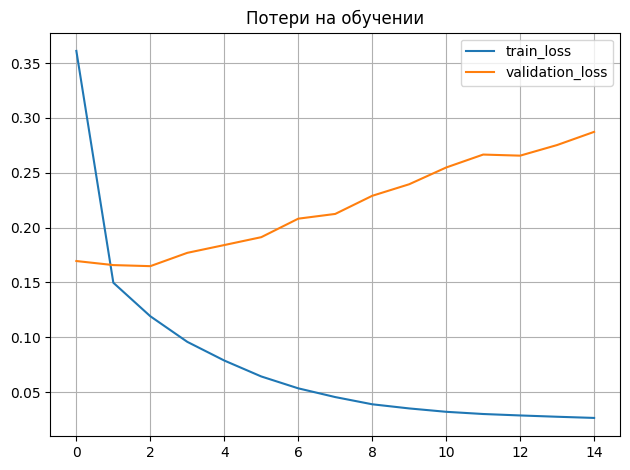

In [43]:
plt.plot(range(num_epochs),
         training_results['train_loss'],
         label = 'train_loss')
plt.plot(range(num_epochs),
         training_results['val_loss'], label = 'validation_loss')
plt.grid()
plt.legend()
plt.title("Потери на обучении")
plt.tight_layout()
plt.show()

BLEU Score:

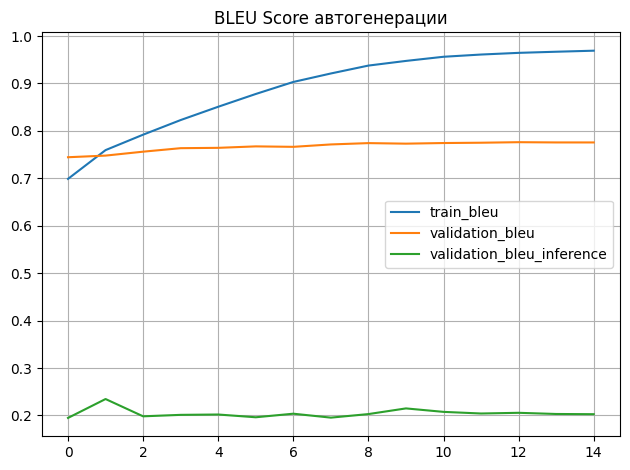

In [45]:
plt.plot(range(num_epochs),
         training_results['train_bleu'],
         label = 'train_bleu')
plt.plot(range(num_epochs),
         training_results['val_bleu'], label = 'validation_bleu')
plt.plot(range(num_epochs),
         training_results['val_bleu_advanced'], label = 'validation_bleu_inference')
plt.grid()
plt.legend()
plt.title("BLEU Score автогенерации")
plt.tight_layout()
plt.show()

Загрузка лучше по validation_loss модели

In [193]:
model_save_path_loss = '/content/drive/MyDrive/final_model_gpt_bigcode.pth'
CodeModel.load_state_dict(torch.load(model_save_path_loss))

<All keys matched successfully>

Инференс:

In [194]:
import ast
max_length = 512

def get_ast_representation(text_code: str) -> str:
				"""
				Получает AST-дерево для кода. Если возникает ошибка при парсинге, возвращает строку 'AST_TOKEN'.

				Параметры:
				- text_code: код в виде текста

				Возвращает AST-дерево или 'AST_TOKEN' в случае ошибки.
				"""
				try:
						# Пытаемся сразу построить AST-дерево
						tree = ast.parse(text_code)
						# Преобразуем AST в строку и возвращаем
						ast_tree = ast.dump(tree, indent=4)
						return ast_tree
				except SyntaxError:
						# Если ошибка, возвращаем 'AST_TOKEN'
						return "AST_TOKEN"

def transform_text(text):
		cleaned_text = ' '.join(text.split())
		transformed_text = f"<FUNC_TOKEN> {cleaned_text}"
		return transformed_text

def transform_text_no_formatting(text):
		cleaned_text = ' '.join(text.split())
		return cleaned_text

def remove_intersection(str1, str2):
		# Найти пересечение двух строк
		intersection = ''.join(set(str1).intersection(set(str2)))

		# Удалить пересечение из каждой строки
		unique_str1 = ''.join([char for char in str1 if char not in intersection])
		unique_str2 = ''.join([char for char in str2 if char not in intersection])

		return unique_str1, unique_str2

def remove_before_substring(text, substring="My Output:"):
		# Найти позицию подстроки
		index = text.find(substring)
		if index != -1:
				# Вернуть часть строки, начиная с подстроки
				return text[index:]
		return text

def remove_common_prefix(str1, str2):
		common_prefix = ""
		min_len = min(len(str1), len(str2))

		for i in range(min_len):
				if str1[i] == str2[i]:
						common_prefix += str1[i]
				else:
						break

		str1_without_prefix = str1[len(common_prefix):]
		str2_without_prefix = str2[len(common_prefix):]

		return str1_without_prefix, str2_without_prefix


def inference_example(code_text, ground_truth, process = False):
	'''Функция для инференса исходного кода (и сравнения с Ground Truth значением при его наличии)'''
	if process == True:
		transformed_text = transform_text(code_text)
		ast = get_ast_representation(code_text)
		input = transformed_text + " " + ast
		input_string = transform_text_no_formatting(input)

		def encode_text(text, tokenizer, tokenizer_flag = True):
			encoding = tokenizer.encode_plus(
			text,
			add_special_tokens=True,
			max_length=max_length if tokenizer_flag else max_length, #* 2,
			padding='max_length',
			truncation=True,
			return_attention_mask=True,
			return_tensors='pt',
			)
			input_ids_code_text = encoding['input_ids'].flatten()
			attention_mask_code_text = encoding['attention_mask'].flatten()
			return input_ids_code_text, attention_mask_code_text

		input_ids_focal_method, attention_mask_focal_method = encode_text(input_string, CodeModel.tokenizerGPT)
		input_ids_response, attention_mask_response = encode_text(ground_truth, CodeModel.tokenizerGPT)

	else:
		input_ids_focal_method, attention_mask_focal_method = code_text['input_ids'], code_text['attention_mask']
		input_ids_response, attention_mask_response = code_text['input_ids_response'], code_text['attention_mask_response']
		input_ids_val, attention_mask_val = code_text['input_ids_for_val'], code_text['attention_mask_for_val']

	CodeModel.eval()
	max_bleu = 0
	with torch.no_grad():
		output_codeLM = CodeModel(input_ids_val.unsqueeze(0).to(device),
										attention_mask_val.unsqueeze(0).to(device),
																input_ids_response.unsqueeze(0).to(device), attention_mask_response.unsqueeze(0).to(device))

		logits = output_codeLM.logits
		logits = logits.detach().cpu().numpy()
		pred_flat = np.argmax(logits, axis=-1)

		argmax_approach = decode_sequence(pred_flat[0], CodeModel.tokenizerGPT)

		# print(f"Размерность словаря: {logits.shape}")
		inputs = {'input_ids': input_ids_val.unsqueeze(0).to(device),
				'attention_mask': attention_mask_val.unsqueeze(0).to(device)}

		# print(inputs)
		# decode_sequence(inputs['input_ids'], CodeModel.tokenizerGPT)

		# Or another approach
		output = CodeModel.gpt2.generate(**inputs,
										max_new_tokens=512,
										do_sample = True,
										top_p = 0.95, num_return_sequences=3)

		delimiters = r'[ \[\]_.{},]'
		output_string = None
		for i in range(3):
			output_string_i = decode_sequence(output[i], CodeModel.tokenizerGPT)
			input_string = decode_sequence(code_text['input_ids'], CodeModel.tokenizerGPT)
			gt_string = decode_sequence(code_text['input_ids_response'], CodeModel.tokenizerGPT)

			gt_string, output_string_i = remove_common_prefix(gt_string, output_string_i)
			# print(gt_string)
			# print(output_string_i)

			# output_string_i, gt_string = remove_intersection(output_string_i, gt_string)
			# print(i)
			# print("Try")
			# print(output_string_i.replace(input_string, " "))
			# print()

			reference = [re.split(delimiters, output_string_i)]
			hypothesis = re.split(delimiters, gt_string)

			smoothing_function = SmoothingFunction().method4
			bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothing_function)
			if bleu_score > max_bleu:
				max_bleu = bleu_score
				output_string = output_string_i

		# output_string = decode_sequence(output[0], CodeModel.tokenizerGPT)
		input_string = decode_sequence(code_text['input_ids'], CodeModel.tokenizerGPT)
		# gt_string = decode_sequence(code_text['input_ids_response'], CodeModel.tokenizerGPT)

		# print("Input string:")
		# print()
		# print(input_string)
		# print()
		# print("Output string:")
		# print(output_string)
		# print()
		# print("Ground Truth string:")
		# print(gt_string)

		# return output_string, gt_string
		# print(input_ids_response.size())
		# print(output.size())

		# bleu_score = average_bleu_score(inputs['input_ids'], output, input_ids_response.unsqueeze(0))
		# print(f"BLEU Score: {max_bleu}")
	return output_string, gt_string

output, gt = inference_example(val_dataset[0], "")

Setting `pad_token_id` to `eos_token_id`:49152 for open-end generation.


In [195]:
print(output.replace("My Output:", '').strip())

def test_subtract_lists_elementwise():
    assert subtract_lists_elementwise([4, 9, 16], [2, 3, 4]) == [2, 6, 12]
    assert subtract_lists_elementwise([4, 9, 16], [0, 0, 0]) == [4, 9, 16]
    assert subtract_lists_elementwise([], [1, 2, 3]) is None
    assert subtract_lists_elementwise([1, 2, 3], []) is None
    assert subtract_lists_elementwise([10, 20, 30], [5, 15, 25]) == [5, 15, 35]
    assert subtract_lists_elementwise([25, 36, 49], [5, 6, 7]) == [5, 15, 35]
    assert subtract_lists_elementwise([1, 3, 5], [1, 3, 5]) == [0, 0, 0]
    assert subtract_lists_elementwise([10, 20, 30], [10, 20, 30]) == [0, 0, 0]
    assert subtract_lists_elementwise([1, 2], [3, 4]) == [-1, -2]
    assert subtract_lists_elementwise([9, 18, 27], [3, 6, 9]) == [9, 18, 27]
    assert subtract_lists_elementwise([2, 4, 6], [5, 7, 8]) == [2, 4, 6]
    assert subtract_lists_elementwise([-1, -2, -3], [-3, -4]) == [-1, -2]
    assert subtract_lists_elementwise([10, 20, 30], [10, 20]) == [0, 20]
    assert subtr

Ground Truth:

In [196]:
print(gt.replace("My Output:", '').strip())

def test_subtract_lists_elementwise():
    assert subtract_lists_elementwise([10, 20, 30], [1, 2, 3]) == [9, 18, 27]
    assert subtract_lists_elementwise([5, 10, 15], [5, 5, 5]) == [0, 5, 10]
    assert subtract_lists_elementwise([], [1, 1, 1]) is None
    assert subtract_lists_elementwise([1, 2], [2, 1]) == [-1, 1]
    assert subtract_lists_elementwise([3, 3, 3], [1, 1]) == [2, 2, 3]
    assert subtract_lists_elementwise([1, 1], [1, 1, 1]) == [0, 0]


Теперь нужно скачать папку с результатами

In [ ]:
# from google.colab import files
# import shutil

# shutil.make_archive("/content/drive/MyDrive/runs/CodeModelLogs", 'zip', "my_folder")

In [ ]:
# files.download("/content/drive/MyDrive/runs.zip")

In [202]:
%load_ext tensorboard
%tensorboard --logdir=/content/runs/CodeModelLogs

<IPython.core.display.Javascript object>

Инференс входной строки

In [197]:
prompt_string = "Generate test cases for a given Python function using its source code. The output should be a series of assert statements that verify the function's correctness. \n\nExample:\n\nInput:\n\ndef add(a, b):\n\treturn a + b\n \n\nOutput:\n\ndef test_add(a, b):\n\n\tassert add(1, 2) == 3\n\tassert add(-1, 1) == 0\n\tassert add(0, 0) == 0\n\tassert add(1.5, 2.5) == 4.0\n\nMy Input:\n\n"
max_length = 512

def input_inference(code_text):
  '''Инференс входной строки кода'''

  model_input = prompt_string + code_text + "\n\nMy Output:\n\n"
  def encode_text(text, tokenizer, tokenizer_flag = True):
      encoding = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=max_length if tokenizer_flag else max_length, #* 2,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
      )
      input_ids_code_text = encoding['input_ids'].flatten()
      attention_mask_code_text = encoding['attention_mask'].flatten()
      return input_ids_code_text, attention_mask_code_text

  input_ids_focal_method, attention_mask_focal_method = encode_text(model_input, CodeModel.tokenizerGPT)

  CodeModel.eval()
  with torch.no_grad():
    # inputs = {'input_ids': input_ids_focal_method.to(device),
		# 		'attention_mask': attention_mask_focal_method.to(device),
    #           'response_ids': input_ids_focal_method.to(device),
		# 		'response_attention_mask': attention_mask_focal_method.to(device)}
    # # print(input_ids_focal_method.size())

    # output_codeLM = CodeModel(**inputs)


    # logits = output_codeLM.logits
    # logits = logits.detach().cpu().numpy()
    # pred_flat = np.argmax(logits, axis=-1)

    inputs = {'input_ids': input_ids_focal_method.unsqueeze(0).to(device),
				'attention_mask': attention_mask_focal_method.unsqueeze(0).to(device)}

    # argmax_approach = decode_sequence(pred_flat[0], CodeModel.tokenizerGPT)

    # print(inputs['input_ids'].size())
    output = CodeModel.gpt2.generate(**inputs,
                      max_new_tokens=512,
                      do_sample = True,
                        top_p = 0.95)

    output_string = decode_sequence(output[0], CodeModel.tokenizerGPT)

    # print(output_string)

  return {
      # 'argmax_output': remove_before_substring(argmax_approach).replace('My Output:', "").strip(),
      'generated_approach': remove_before_substring(output_string).replace('My Output:', "").strip()
  }

code_example = '''def equals_zero(a):
    if a == 0:
      return True
    return False'''



In [198]:
result = input_inference(code_example)

Setting `pad_token_id` to `eos_token_id`:49152 for open-end generation.


In [199]:
print(code_example)

def equals_zero(a):
    if a == 0:
      return True
    return False


In [200]:
print("\n".join(result['generated_approach'].splitlines()[:5]))

def test_equals_zero():
    assert equals_zero(0) is True
    assert equals_zero(1) is False
    assert equals_zero(0) is True
    assert equals_zero(1.5) is False


In [89]:
input_function = decode_sequence(val_dataset[0]['input_ids'], CodeModel.tokenizerGPT)

In [201]:
def extract_text_between_markers(text, start_marker, end_marker):
    start_index = text.find(start_marker)
    end_index = text.find(end_marker)

    if start_index == -1 or end_index == -1 or start_index >= end_index:
        return None

    return text[start_index + len(start_marker):end_index].strip()

print(extract_text_between_markers(input_function, 'My Input:', 'My Output:'))

None


Сохранение

In [ ]:
results_dict = {'function': [], 'output_generated': [],
                'ground_truth': []}

for i in tqdm(range(len(val_dataset))):

  input = val_dataset[i]['input_ids_for_val']
  input = decode_sequence(input, CodeModel.tokenizerGPT)
  # print(input)
  # break

  output = input_inference(input)
  input_function = decode_sequence(val_dataset[i]['input_ids'], CodeModel.tokenizerGPT)
  input_function = extract_text_between_markers(input_function, 'My Input:', 'My Output:')
  # print(input_function)
  output['generated_approach'] = "\n".join(output['generated_approach'].splitlines()[:10])
  # print()
  # print(output['generate_approach'])
  # break
  results_dict['output_generated'].append(output['generated_approach'])
  results_dict['ground_truth'].append(input_function)
  results_dict['function'].append(input_function)


Создаем датасет для дальнейших исследований

In [123]:
output_code_tests_dataset = pd.DataFrame(results_dict)

In [129]:
output_code_tests_dataset['ground_truth'] = output_code_tests_dataset['ground_truth'].str.replace('My Output:', '').str.strip()

In [130]:
output_code_tests_dataset.head()

function  \
0  def subtract_lists_elementwise(lst1, lst2):\n ...   
1  def count_multiples_of(num, arr):\n    count =...   
2  def remove_words_starting_with(s, letter):\n  ...   
3  def choose_string_starting_with_uppercase(*str...   
4  def count_strings_longer_than_avg(lst):\n    i...   

                                    output_generated  \
0  def test_subtract_lists_elementwise():\n    as...   
1  def test_count_multiples_of():\n    assert cou...   
2  def test_remove_words_starting_with():\n    as...   
3  def test_choose_string_starting_with_uppercase...   
4  def test_count_strings_longer_than_avg():\n   ...   

                                        ground_truth  
0  def test_subtract_lists_elementwise():\n    as...  
1  def test_subtract_lists_elementwise():\n    as...  
2  def test_subtract_lists_elementwise():\n    as...  
3  def test_subtract_lists_elementwise():\n    as...  
4  def test_subtract_lists_elementwise():\n    as...

In [131]:
print(output_code_tests_dataset['function'].values[50])

def process_queue_divisible_by_3_not_6(queue):
    result = []
    while queue:
        elem = queue.pop(0)
        if elem % 3 == 0 and elem % 6 != 0:
            result.append(elem)
    if not result:
        return None
    return result


In [132]:
print(output_code_tests_dataset['output_generated'].values[50])

def test_process_queue_divisible_by_3_not_6():
    assert process_queue_divisible_by_3_not_6([3, 6, 9, 12, 15]) == [3, 9, 15]
    assert process_queue_divisible_by_3_not_6([1, 2, 4, 5, 7]) is None
    assert process_queue_divisible_by_3_not_6([-3, -6, -9]) == [-3, -9]
    assert process_queue_divisible_by_3_not_6([0, 3, 6, 15]) == [3, 6, 15]
    assert process_queue_divisible_by_3_not_6([1, 4, 5, 7, 8]) is None
    assert process_queue_divisible_by_3_not_6([-1, -4, -5]) == [-4, -5]
    assert process_queue_divisible_by_3_not_6([3, 3, 3, 3]) == [3, 3, 3]
    assert process_queue_queue_divisible_by_not_6([6, 6, 6]) == [6, 6, 6]
    assert process_queue_divisible_by_3_not_6([]) is None


In [133]:
print(output_code_tests_dataset['ground_truth'].values[50])

def test_subtract_lists_elementwise():
    assert subtract_lists_elementwise([10, 20, 30], [1, 2, 3]) == [9, 18, 27]
    assert subtract_lists_elementwise([5, 10, 15], [5, 5, 5]) == [0, 5, 10]
    assert subtract_lists_elementwise([], [1, 1, 1]) is None
    assert subtract_lists_elementwise([1, 2], [2, 1]) == [-1, 1]
    assert subtract_lists_elementwise([3, 3, 3], [1, 1]) == [2, 2, 3]
    assert subtract_lists_elementwise([1, 1], [1, 1, 1]) == [0, 0]


In [162]:
dict_ = {'ground_truth': []}
for i in tqdm(range(len(val_dataset))):

  input = val_dataset[i]['input_ids_response']
  input = decode_sequence(input, CodeModel.tokenizerGPT)
  # print(input)
  # break
  input = remove_before_substring(input).replace("My Output:", '').strip()
  input = "\n".join(input.splitlines()[:-1])

  # output = input_inference(input)
  # input_function = decode_sequence(val_dataset[i]['input_ids'], CodeModel.tokenizerGPT)
  # input_function = extract_text_between_markers(input_function, 'My Input:', 'My Output:')
  dict_['ground_truth'].append(input)


100%|██████████| 192/192 [00:00<00:00, 291.88it/s]


In [163]:
output_code_tests_dataset['ground_truth'] = dict_['ground_truth']

In [164]:
print(output_code_tests_dataset['function'].values[50])

def process_queue_divisible_by_3_not_6(queue):
    result = []
    while queue:
        elem = queue.pop(0)
        if elem % 3 == 0 and elem % 6 != 0:
            result.append(elem)
    if not result:
        return None
    return result


In [165]:
print(output_code_tests_dataset['output_generated'].values[50])

def test_process_queue_divisible_by_3_not_6():
    assert process_queue_divisible_by_3_not_6([3, 6, 9, 12, 15]) == [3, 9, 15]
    assert process_queue_divisible_by_3_not_6([1, 2, 4, 5, 7]) is None
    assert process_queue_divisible_by_3_not_6([-3, -6, -9]) == [-3, -9]
    assert process_queue_divisible_by_3_not_6([0, 3, 6, 15]) == [3, 6, 15]
    assert process_queue_divisible_by_3_not_6([1, 4, 5, 7, 8]) is None
    assert process_queue_divisible_by_3_not_6([-1, -4, -5]) == [-4, -5]
    assert process_queue_divisible_by_3_not_6([3, 3, 3, 3]) == [3, 3, 3]
    assert process_queue_queue_divisible_by_not_6([6, 6, 6]) == [6, 6, 6]
    assert process_queue_divisible_by_3_not_6([]) is None


In [166]:
print(output_code_tests_dataset['ground_truth'].values[50])

def test_process_queue_divisible_by_3_not_6():
    assert process_queue_divisible_by_3_not_6([3, 6, 9, 12, 15]) == [3, 9, 15]
    assert process_queue_divisible_by_3_not_6([6, 12, 18]) is None
    assert process_queue_divisible_by_3_not_6([3, 9, 15, 21]) == [3, 9, 15, 21]
    assert process_queue_divisible_by_3_not_6([]) is None
    assert process_queue_divisible_by_3_not_6([3, 6, 9]) == [3, 9]
    assert process_queue_divisible_by_3_not_6([12, 15, 18]) == [15]
    assert process_queue_divisible_by_3_not_6([4, 8, 14]) is None
    assert process_queue_divisible_by_3_not_6([3, 27, 9]) == [3, 27, 9]


In [167]:
output_code_tests_dataset.head()

function  \
0  def subtract_lists_elementwise(lst1, lst2):\n ...   
1  def count_multiples_of(num, arr):\n    count =...   
2  def remove_words_starting_with(s, letter):\n  ...   
3  def choose_string_starting_with_uppercase(*str...   
4  def count_strings_longer_than_avg(lst):\n    i...   

                                    output_generated  \
0  def test_subtract_lists_elementwise():\n    as...   
1  def test_count_multiples_of():\n    assert cou...   
2  def test_remove_words_starting_with():\n    as...   
3  def test_choose_string_starting_with_uppercase...   
4  def test_count_strings_longer_than_avg():\n   ...   

                                        ground_truth  
0  def test_subtract_lists_elementwise():\n    as...  
1  def test_count_multiples_of():\n    assert cou...  
2  def test_remove_words_starting_with():\n    as...  
3  def test_choose_string_starting_with_uppercase...  
4  def test_count_strings_longer_than_avg():\n   ...

In [168]:
output_code_tests_dataset.to_csv('output_code_tests_dataset.csv', index=False)